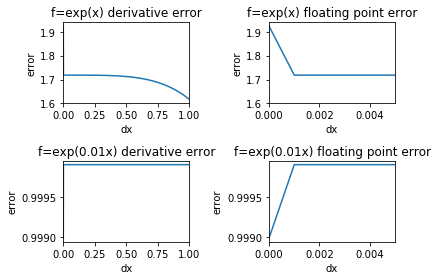

In [1]:
# Problem 1:
import numpy as np
import matplotlib.pyplot as plt

def fourptsderiv(x, dx, fun):
    return (8*(fun(x+dx)-fun(x-dx))-(fun(x+2*dx)-fun(x-2*dx)))/(12*dx) # + O(dx^4f^(4)(x))

# Test functions with true derivatives
f1 = np.exp
df1 = np.exp
def f2(x):
    return np.exp(0.01*x)
def df2(x):
    return 0.01*np.exp(0.01*x)

def derivative_err_dx(x, fun, dfun): # Derivative error as a function of dx
    num_tests = 1000
    err_list = np.zeros(num_tests)
    dx_list = np.linspace(1, 10e-16, num_tests)
    for n in range (len(dx_list)):
        err_list[n] = np.abs(x - fourptsderiv(x, dx_list[n], dfun))
    
    return dx_list, err_list


plt.clf()
plt.figure()

dx_list, err_list = derivative_err_dx(1, f1, df1)
plt.subplot(221)
plt.plot(dx_list, err_list)
plt.xlabel('dx')
plt.ylabel('error')
plt.xlim(left=0, right=1)
plt.title('f=exp(x) derivative error')

plt.subplot(222)
plt.plot(dx_list, err_list)
plt.xlabel('dx')
plt.ylabel('error')
plt.xlim(left=0, right=0.005)
plt.title('f=exp(x) floating point error')

dx_list, err_list = derivative_err_dx(1, f2, df2)
plt.subplot(223)
plt.plot(dx_list, err_list)
plt.xlabel('dx')
plt.ylabel('error')
plt.xlim(left=0, right=1)
plt.title('f=exp(0.01x) derivative error')

plt.subplot(224)
plt.plot(dx_list, err_list)
plt.xlabel('dx')
plt.ylabel('error')
plt.xlim(left=0, right=0.005)
plt.title('f=exp(0.01x) floating point error')

plt.tight_layout()

plt.savefig("images\Derivative_Error.png")
plt.show()

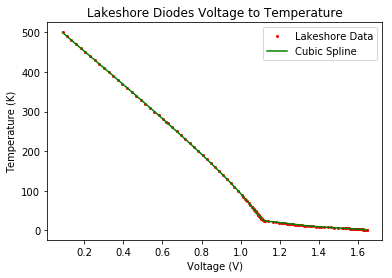

rms error: 1.532961348917533e-05


In [6]:
# Problem 2:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

diodes = np.transpose(np.loadtxt('lakeshore.txt'))

plt.clf()
plt.plot(diodes[1], diodes[0], 'ro', markersize=2, label="Lakeshore Data")
plt.xlabel('Voltage (V)')
plt.ylabel('Temperature (K)')

# Neighbours cubic spline
interval_num = 1000
cubic_spline = interpolate.interp1d(diodes[1], diodes[0], kind='cubic')
x_spline = np.linspace(diodes[1,len(diodes[1])-1], diodes[1,0], interval_num)
y_spline = cubic_spline(x_spline)
plt.plot(x_spline, y_spline, 'g-', label="Cubic Spline")
plt.title("Lakeshore Diodes Voltage to Temperature")
plt.legend()

plt.savefig('images\LakeShore_Interpolated_VoltageToTemp')
plt.show()

# Error
x_shift = np.abs(diodes[1,len(diodes[1])-1] - diodes[1,0]) / (2.0 * interval_num) # half-step shift
x_spline_shift = np.linspace(diodes[1, len(diodes[1])-1]+x_shift, diodes[1,0]-x_shift, interval_num-1) # shifted x values
y_spline_shift = cubic_spline(x_spline_shift) # interpolated value shifted
yy_spline_shift = interpolate.interp1d(x_spline_shift, y_spline_shift, kind='cubic') # interpolation of shifted interpolation

# remove first and last element to be in interpolation range
xx_diodes = np.copy(diodes[1])
xx_diodes = np.delete(xx_diodes, 0)
xx_diodes = np.delete(xx_diodes, len(xx_diodes)-1)

# interpolated y values not shifted
yy_diodes = yy_spline_shift(xx_diodes)

err = 0
for i in range (len(yy_diodes) - 1):
    err += (yy_diodes[i] - diodes[0,i+1])**2
err /= len(yy_diodes)
err = np.sqrt(err)
print('rms error: ' + str(err))

In [3]:
# Problem 3:
import numpy as np
import matplotlib.pyplot as plt

ncall = 3 # Number of integration calls
ncall_saved = 0 # Number of call saved instead of doing lazy integration

def var_step_siz_integrate(fun, a, b, tol): # manager

    x_mid = (a+b)/2.0
    f, err = integrator(fun, a, x_mid, b, fun(a), fun(x_mid), fun(b), tol)
    # print(f, err, ncall)
    return f, err

def integrator(fun, x0, x2, x4, y0, y2, y4, tol):
    global ncall
    global ncall_saved
    
    x_range = x4 - x0
    
    # Non-limit points, x2 given
    x1 = x0 + x_range/4.0
    x3 = x4 - x_range/4.0
    y1 = fun(x1)
    y3 = fun(x3)
    
    ncall += 2
    ncall_saved += 3
    
    f1 = (y0 + 4*y2 + y4)*(x_range)/6.0 # Simpson's: O(dx^5f^4)
    f2 = (y0 + 4*y1 + 2*y2 + 4*y3 + y4)*(x_range)/12.0 # Simpsons's: O(dx^7f^6)
    err = np.abs(f2 - f1)
    
    if (err<tol):
        return f2, err
    
    else:
        l_integral, l_err = integrator(fun, x0, x1, x2, y0, y1, y2, tol/2.0)
        r_integral, r_err = integrator(fun, x2, x3, x4, y2, y3, y4, tol/2.0)
        
        integral = l_integral + r_integral
        err = l_err + r_err
        return integral, err

# test functions
def fun1(x):
    return 1.0/(1.0+x**2)

def fun2(x):
    return np.sin(x)

def fun3(x): # example that fails
    return np.sin(1.0/x)

fun1_val, fun1_err = var_step_siz_integrate(fun1, -1, 1, 10e-6)
fun1_ncall = ncall
fun1_ncall_saved = ncall_saved

fun2_val, fun2_err = var_step_siz_integrate(fun2, -1, 1, 10e-6)
fun2_ncall = ncall
fun2_ncall_saved = ncall_saved

print('f(x)=1/(1+x^2), -1<x<1:\n')
print('Value: ' + str(fun1_val) + ' , Error: ' + str(fun1_err) + '\n')
print('Number of calls: ' + str(fun1_ncall) + ', Number of calls saved from the lazy integration: ' + str(fun1_ncall_saved) + '\n\n')

print('f(x)=sin(x), -1<x<1:\n')
print('Value: ' + str(fun2_val) + ' , Error: ' + str(fun2_err) + '\n')
print('Number of calls: ' + str(fun2_ncall) + ', Number of calls saved from the lazy integration: ' + str(fun2_ncall_saved) + '\n\n')


f(x)=1/(1+x^2), -1<x<1:

Value: 1.570796204964867 , Error: 3.5781273818313863e-06

Number of calls: 57, Number of calls saved from the lazy integration: 81


f(x)=sin(x), -1<x<1:

Value: -3.700743415417188e-17 , Error: 3.700743415417188e-17

Number of calls: 59, Number of calls saved from the lazy integration: 84




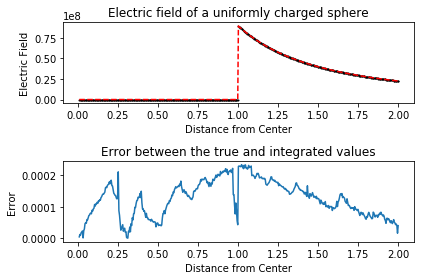

In [4]:
# Problem 4:
from scipy import integrate
import sys

e0 = 8.854e-10 # Permittivity
R = 1.0 # Sphere radius
Q = 1.0 # Total Charge
o = Q/(4.0*np.pi*R**2) # Area charge density
z = 2.0 # Sphere distance
factor = o*R/2/e0 # In front of the integral
tol = 10e-3 # Tolerance

l_bound = 0.5*np.pi
u_bound = -0.5*np.pi
def fun_toIntegrate(t):
    top = np.cos(t)*(R*np.sin(t)-z) #R*np.sin(t)-z
    bot = ((z-R*np.sin(t))**2 + (R*np.cos(t))**2)**1.5
    return factor*top/bot

def true_value(z):
        if (z>R):
            return Q/(4*np.pi*e0*z**2)
        else:
            return 0

num_x = 500
x_vals = np.linspace(10e-3, R+1, num_x)
f_vals = np.zeros(num_x)
f_errs = np.zeros(num_x)

sys.setrecursionlimit(3000)
for i in range (len(x_vals)):
    z = x_vals[i]
    val_tmp, err_tmp = var_step_siz_integrate(fun_toIntegrate, l_bound, u_bound, tol)
    f_vals[i] = val_tmp
    f_errs[i] = err_tmp

plt.clf()

ax1=plt.subplot(211)
plt.plot(x_vals, f_vals, 'ko', markersize=1)
plt.title("Electric field of a uniformly charged sphere")
plt.xlabel('Distance from Center')
plt.ylabel('Electric Field')

# True function
y_true = np.zeros(num_x)
for i in range(len(x_vals)):
    y_true[i] = true_value(x_vals[i])

plt.plot(x_vals, y_true, 'r--')


ax2=plt.subplot(212, sharex=ax1)
plt.plot(x_vals, np.abs(y_true - f_vals))
plt.title('Error between the true and integrated values')
plt.xlabel('Distance from Center')
plt.ylabel('Error')

plt.savefig('images\ElectricFieldSphere', bbox_inches="tight")
plt.tight_layout()
plt.show()

C:\Users\ngren\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


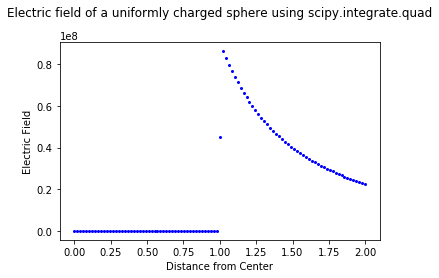

In [5]:
num_x = 99
x_vals = np.linspace(0, R+1, num_x)
f_vals = np.zeros(num_x)

for i in range (len(x_vals)):
    z = x_vals[i]
    f1, f2 = integrate.quad(fun_toIntegrate, l_bound, u_bound)
    f_vals[i] = f1
    
plt.plot(x_vals, f_vals, 'bo', markersize=2)
plt.title('Electric field of a uniformly charged sphere using scipy.integrate.quad', y=1.1)
plt.xlabel('Distance from Center')
plt.ylabel('Electric Field')

plt.savefig('images\ElectrifieldSphereScipyQuad', bbox_inches="tight")
plt.tight_layout()
plt.show()